## 1. Packaging

In [13]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np # to use numpy arrays instead of lists
import pandas as pd # DataFrame (table)

# Matplotlib and seaborn for charting
import matplotlib.pyplot as plt # to plot
import seaborn as sns # to plot

In [14]:
# Sklearn processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [15]:
# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, AveragePooling1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
!pip install keras-tuner # Install keras-tuner
import keras_tuner as kt # Now import keras_tuner

In [16]:
# Custom analysis modules
from analysis_modules import *

np.random.seed(0)
tf.random.set_seed(0) 

## 2. Read file and load data

### 2.1 Read file

In [17]:
# Load data
data_file = "Amazon_Unlocked_Mobile.csv"
datos = pd.read_csv(data_file, header=0)

In [18]:
# View data information
describeData(datos)

                                        Product Name Brand Name   Price  \
0  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
1  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
2  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
3  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   
4  "CLEAR CLEAN ESN" Sprint EPIC 4G Galaxy SPH-D7...    Samsung  199.99   

   Rating                                            Reviews  Review Votes  
0       5  I feel so LUCKY to have found this used (phone...           1.0  
1       4  nice phone, nice up grade from my pantach revu...           0.0  
2       5                                       Very pleased           0.0  
3       4  It works good but it goes slow sometimes but i...           0.0  
4       4  Great phone to replace my lost phone. The only...           0.0  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data co

### 2.2 Preprocessing

In [19]:
def encodeData(dataSet=0):
    """
    Preprocess data
    """
    
    # Eliminate null values
    dataSet.dropna(inplace=True)
    # Work with a sample of 100,000 rows
    dataSet = dataSet.iloc[0:100000,:]

    # Remove any 'neutral' ratings equal to 3
    dataSet = dataSet[dataSet['Rating'] != 3]

    # Encode 4s and 5s as 1 (rated positively)
    # Encode 1s and 2s as 0 (rated poorly)
    dataSet['Clasification'] = np.where(dataSet['Rating'] > 3, 1, 0)

    # Keep only relevant columns
    columnas = ['Reviews', 'Rating', 'Clasification']
    dataSet = dataSet[columnas]

    return dataSet

In [20]:
# Preprocess data
misDatos = encodeData(datos)
print(misDatos.head())
print()
print(misDatos.iloc[:,-1:].sum())
print()

                                             Reviews  Rating  Clasification
0  I feel so LUCKY to have found this used (phone...       5              1
1  nice phone, nice up grade from my pantach revu...       4              1
2                                       Very pleased       5              1
3  It works good but it goes slow sometimes but i...       4              1
4  Great phone to replace my lost phone. The only...       4              1

Clasification    70037
dtype: int64



### 2.3 Split Data

In [21]:
columnas = ['Reviews', 'Clasification']
misDatos = misDatos[columnas]
print(misDatos.head())

                                             Reviews  Clasification
0  I feel so LUCKY to have found this used (phone...              1
1  nice phone, nice up grade from my pantach revu...              1
2                                       Very pleased              1
3  It works good but it goes slow sometimes but i...              1
4  Great phone to replace my lost phone. The only...              1


In [22]:
# Extract labels
# Convert one-hot encoding to single label
y_onehot = misDatos.iloc[:, -1:].to_numpy()
y_label = np.argmax(y_onehot, axis=1)

# Split data into training and test sets
ts_size = .25
[trainSet, testSet] = splitDataSet(misDatos, test_size=ts_size, randSplit=True, stratify=y_label)
print("Train set")
print(trainSet.head())
print()
print('trainSet shape: ', trainSet.shape)
print()
print(trainSet.iloc[:,-1:].sum())
print()
print("Test set")
print(testSet.head())
print()
print('testSet shape: ', testSet.shape)
print()
print(testSet.iloc[:,-1:].sum())
print()

Train set
                                                  Reviews  Clasification
2267    Great build quality. Almost stock Android. Lit...              1
88968                                          excelente!              1
94479   Soy de venezuela el producto vino malo, lo man...              0
113000                                         Excelente.              1
72560                                                good              1

trainSet shape:  (70160, 2)

Clasification    52501
dtype: int64

Test set
                                                 Reviews  Clasification
44794  The selphone is super nice ,my daugter love't ...              1
25359  No it did not, you can't hear when you have it...              0
59842  The iPhone 6 Plus arrived on-time and in perfe...              1
69634  Finally picked one up after a year of contempl...              1
19566  I bought this used and it had few noticeable s...              1

testSet shape:  (23387, 2)

Clasification  

### 2.4 Vectorize

In [23]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

training_sentences= trainSet['Reviews']
training_labels = trainSet['Clasification']
testing_sentences = testSet['Reviews']
testing_labels = testSet['Clasification']

In [24]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [25]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

## 3. CNN

In [26]:
# CNN classifier
# Neural Network TF architecture
model = Sequential([
                    Embedding(vocab_size, embedding_dim, input_length=max_length),
                    Conv1D(filters=2, kernel_size=3, activation='relu', name="Conv1D"),
                    AveragePooling1D(pool_size=3),
                    Flatten(),
                    Dense(2, activation='relu'),
                    Dense(1, activation='sigmoid', name="Outpul_layer")
                    ])

opt = 'adam'
loss_fun = 'binary_crossentropy'
acc = ['accuracy']

model.compile(
    optimizer = opt,
    loss = loss_fun,
    metrics = acc
    )

2025-10-08 16:23:26.603991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 Conv1D (Conv1D)             (None, 98, 2)             98        
                                                                 
 average_pooling1d (AverageP  (None, 32, 2)            0         
 ooling1D)                                                       
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
 Outpul_layer (Dense)        (None, 1)                 3         
                                                        

In [28]:
num_epochs = 30
history = model.fit(training_padded,
                    training_labels,
                    validation_split=0.1,
                    epochs=num_epochs,
                    verbose=2)

Epoch 1/30
1974/1974 - 12s - loss: 0.2436 - accuracy: 0.9033 - val_loss: 0.1381 - val_accuracy: 0.9521 - 12s/epoch - 6ms/step
Epoch 2/30
1974/1974 - 11s - loss: 0.1168 - accuracy: 0.9623 - val_loss: 0.1161 - val_accuracy: 0.9647 - 11s/epoch - 5ms/step
Epoch 3/30
1974/1974 - 8s - loss: 0.0889 - accuracy: 0.9736 - val_loss: 0.1081 - val_accuracy: 0.9681 - 8s/epoch - 4ms/step
Epoch 4/30
1974/1974 - 10s - loss: 0.0726 - accuracy: 0.9787 - val_loss: 0.1048 - val_accuracy: 0.9702 - 10s/epoch - 5ms/step
Epoch 5/30
1974/1974 - 11s - loss: 0.0617 - accuracy: 0.9828 - val_loss: 0.1033 - val_accuracy: 0.9722 - 11s/epoch - 5ms/step
Epoch 6/30
1974/1974 - 9s - loss: 0.0522 - accuracy: 0.9856 - val_loss: 0.1067 - val_accuracy: 0.9723 - 9s/epoch - 5ms/step
Epoch 7/30
1974/1974 - 11s - loss: 0.0454 - accuracy: 0.9879 - val_loss: 0.1059 - val_accuracy: 0.9745 - 11s/epoch - 6ms/step
Epoch 8/30
1974/1974 - 13s - loss: 0.0393 - accuracy: 0.9898 - val_loss: 0.1078 - val_accuracy: 0.9753 - 13s/epoch - 7ms/s

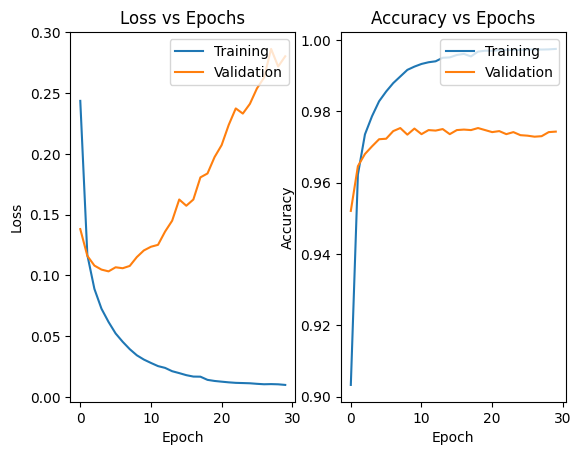

In [29]:
fig = plt.figure()
fig.add_subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss vs Epochs")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 4. Metrics

In [30]:
print(model.evaluate(training_padded, training_labels, verbose=2))
print("\n")

#### predict train data ######
df_train = pd.DataFrame()
df_train['real'] = training_labels
df_train['pred'] = model.predict(training_padded).reshape(1,len(training_padded))[0]
print(round(df_train))
print(model.evaluate(testing_padded,testing_labels, verbose=2))
print("\n")

# test data
df_test = pd.DataFrame()
df_test['real'] = testing_labels
df_test['pred'] = model.predict(testing_padded).reshape(1,len(testing_padded))[0]
print(round(df_test))


2193/2193 - 2s - loss: 0.0364 - accuracy: 0.9953 - 2s/epoch - 1ms/step
[0.03644387423992157, 0.9953392148017883]


2193/2193 [==============================] - 4s 2ms/step
       real  pred
0         1   1.0
1         1   1.0
2         0   0.0
3         1   1.0
4         1   1.0
...     ...   ...
70155     1   1.0
70156     1   1.0
70157     0   0.0
70158     1   1.0
70159     0   0.0

[70160 rows x 2 columns]
731/731 - 1s - loss: 0.2943 - accuracy: 0.9730 - 835ms/epoch - 1ms/step
[0.2943435311317444, 0.9730191826820374]


731/731 [==============================] - 1s 2ms/step
       real  pred
0         1   1.0
1         0   0.0
2         1   1.0
3         1   1.0
4         1   1.0
...     ...   ...
23382     1   1.0
23383     0   0.0
23384     1   1.0
23385     1   1.0
23386     1   1.0

[23387 rows x 2 columns]


## 5. CNN with Keras Tuner

In [31]:
# CNN using function for Keras Tuner
def model_builder(hp):
    vocab_size = 10000
    embedding_dim = 16
    hp_max_length = hp.Int('input_length', min_value=80, max_value=120, step=10)
    model = Sequential([
                      Embedding(vocab_size, embedding_dim, input_length=hp_max_length),
                      Conv1D(filters=2, kernel_size=3, activation='relu', name="Conv1D"),
                      AveragePooling1D(pool_size=3),
                      Flatten(),
                      Dense(2, activation='relu'),
                      Dense(1, activation='sigmoid', name="Outpul_layer")
                      ])
    opt = 'adam'
    loss_fun = 'binary_crossentropy'
    acc = ['accuracy']

    model.compile(
        optimizer = opt,
        loss = loss_fun,
        metrics = acc
        )

    return model

In [32]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     )

In [33]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [34]:
num_epochs = 30

tuner.search(training_padded,
             training_labels,
             validation_split=0.1,
             epochs=num_epochs,
             callbacks=[stop_early],
             verbose=2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete.
The best 'input_length' for the embedding layer is {best_hps.get('input_length')}
""")

Trial 5 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.9676454067230225
Total elapsed time: 00h 00m 27s
The hyperparameter search is complete.
The best 'input_length' for the embedding layer is 100



In [35]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(training_padded,
                    training_labels,
                    validation_split=0.1,
                    epochs=num_epochs,
                    verbose=2)

Epoch 1/30
1974/1974 - 12s - loss: 0.2817 - accuracy: 0.8948 - val_loss: 0.1769 - val_accuracy: 0.9470 - 12s/epoch - 6ms/step
Epoch 2/30
1974/1974 - 9s - loss: 0.1434 - accuracy: 0.9588 - val_loss: 0.1402 - val_accuracy: 0.9578 - 9s/epoch - 5ms/step
Epoch 3/30
1974/1974 - 9s - loss: 0.1077 - accuracy: 0.9695 - val_loss: 0.1370 - val_accuracy: 0.9575 - 9s/epoch - 5ms/step
Epoch 4/30
1974/1974 - 9s - loss: 0.0912 - accuracy: 0.9751 - val_loss: 0.1233 - val_accuracy: 0.9624 - 9s/epoch - 4ms/step
Epoch 5/30
1974/1974 - 8s - loss: 0.0814 - accuracy: 0.9781 - val_loss: 0.1182 - val_accuracy: 0.9664 - 8s/epoch - 4ms/step
Epoch 6/30
1974/1974 - 8s - loss: 0.0724 - accuracy: 0.9808 - val_loss: 0.1191 - val_accuracy: 0.9691 - 8s/epoch - 4ms/step
Epoch 7/30
1974/1974 - 8s - loss: 0.0673 - accuracy: 0.9826 - val_loss: 0.1218 - val_accuracy: 0.9684 - 8s/epoch - 4ms/step
Epoch 8/30
1974/1974 - 8s - loss: 0.0616 - accuracy: 0.9850 - val_loss: 0.1243 - val_accuracy: 0.9686 - 8s/epoch - 4ms/step
Epoch 

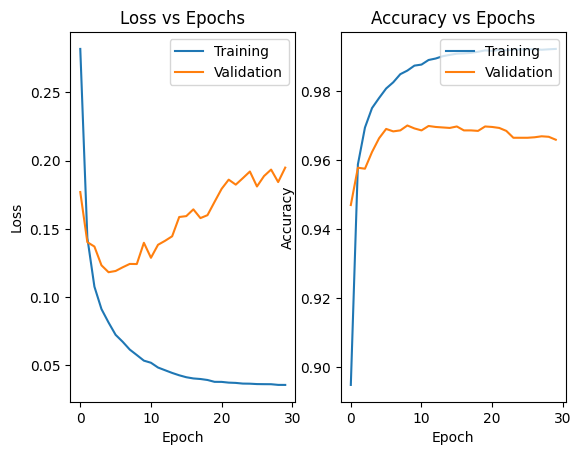

In [36]:
fig = plt.figure()
fig.add_subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss vs Epochs")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 6. Metrics

In [37]:
print(model.evaluate(training_padded, training_labels, verbose=2))
print("\n")

#### predict train data ######
df_train = pd.DataFrame()
df_train['real'] = training_labels
df_train['pred'] = model.predict(training_padded).reshape(1,len(training_padded))[0]
print(round(df_train))
print(model.evaluate(testing_padded,testing_labels, verbose=2))
print("\n")

# test data
df_test = pd.DataFrame()
df_test['real'] = testing_labels
df_test['pred'] = model.predict(testing_padded).reshape(1,len(testing_padded))[0]
print(round(df_test))

2193/2193 - 2s - loss: 0.0509 - accuracy: 0.9897 - 2s/epoch - 977us/step
[0.05090327188372612, 0.9897235035896301]


2193/2193 [==============================] - 2s 1ms/step
       real  pred
0         1   1.0
1         1   1.0
2         0   0.0
3         1   1.0
4         1   1.0
...     ...   ...
70155     1   1.0
70156     1   1.0
70157     0   0.0
70158     1   1.0
70159     0   0.0

[70160 rows x 2 columns]
731/731 - 1s - loss: 0.1767 - accuracy: 0.9673 - 751ms/epoch - 1ms/step
[0.17674416303634644, 0.9672895073890686]


731/731 [==============================] - 1s 1ms/step
       real  pred
0         1   1.0
1         0   0.0
2         1   1.0
3         1   1.0
4         1   1.0
...     ...   ...
23382     1   1.0
23383     0   0.0
23384     1   1.0
23385     1   1.0
23386     1   1.0

[23387 rows x 2 columns]


## 7. CNN with Keras Tuner (second model)

In [38]:
# CNN using function for Keras Tuner (second model)
def model_builder2(hp):
    vocab_size = 10000
    hp_embedding_dim = hp.Int('embedding_dim', min_value=8, max_value=40 , step=8)
    hp_max_length = hp.Int('input_length', min_value=80, max_value=120, step=10)
    hp_filters = hp.Int('filters', min_value=2, max_value=10, step=2)
    hp_units = hp.Int('units', min_value=2, max_value=16, step=2)
    hp_activation_conv = hp.Choice('activation_conv', values=['relu', 'sigmoid', 'tanh'])
    hp_activation_dense = hp.Choice('activation_dense', values=['relu', 'sigmoid', 'tanh'])
    model = Sequential([
                      Embedding(vocab_size, hp_embedding_dim, input_length=hp_max_length),
                      Conv1D(filters=hp_filters, kernel_size=3, activation=hp_activation_conv, name="Conv1D"),
                      AveragePooling1D(pool_size=3),
                      Flatten(),
                      Dense(units=hp_units, activation=hp_activation_dense),
                      Dense(1, activation='sigmoid', name="Outpul_layer")
                      ])
    opt = 'adam'
    loss_fun = 'binary_crossentropy'
    acc = ['accuracy']

    model.compile(
        optimizer = opt,
        loss = loss_fun,
        metrics = acc
        )

    return model

In [39]:
cnn_tuner2 = kt.Hyperband(model_builder2,
                     objective='val_accuracy',
                     max_epochs=12,
                     factor=3,
                     )

Reloading Tuner from ./untitled_project/tuner0.json


In [40]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [41]:
num_epochs = 30

cnn_tuner2.search(training_padded,
             training_labels,
             validation_split=0.1,
             epochs=num_epochs,
             callbacks=[stop_early],
             verbose=2)

# Get the optimal hyperparameters
cnn_best_hps2=cnn_tuner2.get_best_hyperparameters(num_trials=1)[0]

print("""The hyperparameter search is complete.
The best input_length for the embedding layer is""", cnn_best_hps2.get('input_length'))

The hyperparameter search is complete.
The best input_length for the embedding layer is 100


In [42]:
model_tuner = cnn_tuner2.hypermodel.build(cnn_best_hps2)

history_tuner = model_tuner.fit(training_padded,
                    training_labels,
                    validation_split=0.1,
                    epochs=num_epochs,
                    verbose=2)

Epoch 1/30
1974/1974 - 7s - loss: 0.2576 - accuracy: 0.8912 - val_loss: 0.1557 - val_accuracy: 0.9390 - 7s/epoch - 4ms/step
Epoch 2/30
1974/1974 - 6s - loss: 0.1323 - accuracy: 0.9545 - val_loss: 0.1244 - val_accuracy: 0.9582 - 6s/epoch - 3ms/step
Epoch 3/30
1974/1974 - 6s - loss: 0.0998 - accuracy: 0.9685 - val_loss: 0.1137 - val_accuracy: 0.9651 - 6s/epoch - 3ms/step
Epoch 4/30
1974/1974 - 6s - loss: 0.0808 - accuracy: 0.9757 - val_loss: 0.1100 - val_accuracy: 0.9676 - 6s/epoch - 3ms/step
Epoch 5/30
1974/1974 - 6s - loss: 0.0688 - accuracy: 0.9804 - val_loss: 0.1048 - val_accuracy: 0.9719 - 6s/epoch - 3ms/step
Epoch 6/30
1974/1974 - 6s - loss: 0.0591 - accuracy: 0.9833 - val_loss: 0.1077 - val_accuracy: 0.9725 - 6s/epoch - 3ms/step
Epoch 7/30
1974/1974 - 6s - loss: 0.0519 - accuracy: 0.9856 - val_loss: 0.1054 - val_accuracy: 0.9723 - 6s/epoch - 3ms/step
Epoch 8/30
1974/1974 - 6s - loss: 0.0458 - accuracy: 0.9878 - val_loss: 0.1085 - val_accuracy: 0.9746 - 6s/epoch - 3ms/step
Epoch 9/

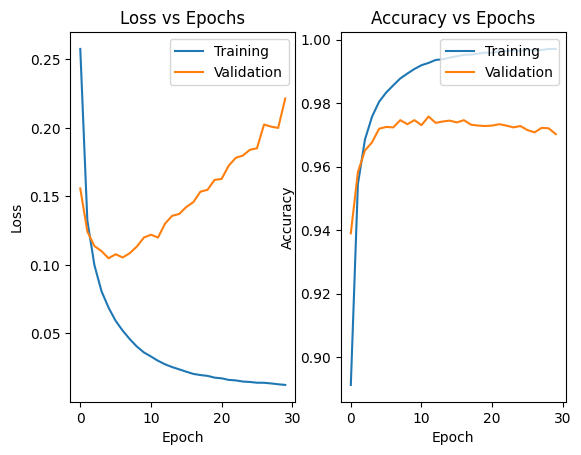

In [43]:
fig = plt.figure()
fig.add_subplot(121)
plt.plot(history_tuner.history['loss'])
plt.plot(history_tuner.history['val_loss'])
plt.title("Loss vs Epochs")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(history_tuner.history['accuracy'])
plt.plot(history_tuner.history['val_accuracy'])
plt.title("Accuracy vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## 8. Metrics

In [44]:
print(model_tuner.evaluate(training_padded, training_labels, verbose=2))
print("\n")

#### predict train data ######
df_train = pd.DataFrame()
df_train['real'] = training_labels
df_train['pred'] = model_tuner.predict(training_padded).reshape(1,len(training_padded))[0]
print(round(df_train))
print(model_tuner.evaluate(testing_padded,testing_labels, verbose=2))
print("\n")

# test data
df_test = pd.DataFrame()
df_test['real'] = testing_labels
df_test['pred'] = model_tuner.predict(testing_padded).reshape(1,len(testing_padded))[0]
print(round(df_test))

2193/2193 - 5s - loss: 0.0327 - accuracy: 0.9946 - 5s/epoch - 2ms/step
[0.032662395387887955, 0.9946408271789551]


2193/2193 [==============================] - 7s 3ms/step
       real  pred
0         1   1.0
1         1   1.0
2         0   0.0
3         1   1.0
4         1   1.0
...     ...   ...
70155     1   1.0
70156     1   1.0
70157     0   0.0
70158     1   1.0
70159     0   0.0

[70160 rows x 2 columns]
731/731 - 2s - loss: 0.2401 - accuracy: 0.9719 - 2s/epoch - 2ms/step
[0.24011987447738647, 0.9719074964523315]


731/731 [==============================] - 2s 2ms/step
       real  pred
0         1   1.0
1         0   0.0
2         1   1.0
3         1   1.0
4         1   1.0
...     ...   ...
23382     1   1.0
23383     0   0.0
23384     1   1.0
23385     1   1.0
23386     1   1.0

[23387 rows x 2 columns]
